## Mod03 Project

In [ ]:
# Import Libraries:
import numpy as np
import pandas as pd

# Statistics Libraries:
import scipy.stats as stats
import statsmodels as sm
from statsmodels.formula.api import ols
import itertools

# Ploting Libraries:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# SQL
import sqlite3 
conn = sqlite3.connect('database.sqlite3')
cur = conn.cursor()

## Global Functions

In [2]:
def get_sample(data, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(data)
        sample.append(x)
    return sample

def get_sample_mean(sample):
    return sum(sample)/len(sample)

def create_sample_distribution(data, dist_size=100, n=30):
    sample_distribution_means = []
    while len(sample_distribution_means) != dist_size:
        sample = get_sample(data, n)
        sample_mean = get_sample_mean(sample)
        sample_distribution_means.append(sample_mean)
    return sample_distribution_means

In [3]:
def one_sample_ttest(sample, popmean, alpha):

    # Visualize sample distribution for normality 
    #binsize = int(len(sample)/3)
    #sns.distplot(sample, bins=binsize)
    
    # Population mean
    mu = popmean

    # Sample mean (x̄) using NumPy mean()
    x_bar = np.mean(sample)

    # Sample Standard Deviation (sigma) using Numpy
    sample_std = np.std(sample)
    
    # Degrees of freedom
    dof = len(sample)-1
    
    # Calculate the critical t-value
    t_crit = stats.t.ppf(1- alpha, dof)
   
    # Calculate the t-value and p-value      t = (x_bar - mu)/(sample_std/math.sqrt(len(sample)))
    t1, p1 = stats.ttest_1samp(sample, mu)
    
    if (abs(t1)>t_crit) and (p1<alpha):
        print("Reject Null_H! The results are statistically significant.")
        print("Mean Diff:", mu-x_bar)
        print("t-stat = ", round(t1,3), "\nt_crit", round(t_crit,3), "\nP_value = ", round(p1,3), "\nAlpha", alpha)
    
    else:
        print("Do NOT Reject Null_H. The results are NOT statistically significant.")
        rint("Mean Diff:", mu-x_bar)
        print("t-stat = ", round(t1,3), "\nt_crit", round(t_crit,3), "\nP_value = ", round(p1,3), "\nAlpha", alpha)
     
    # return results
    return None

In [4]:
def two_sample_ttest(sample1, sample2, alpha):
    n_sample1 = len(sample1)
    n_sample2 = len(sample2)
    t_stat, P_value = stats.ttest_ind(sample1, sample2)
    t_crit = stats.t.ppf(1-(alpha/2), (n_sample1+n_sample2-2))
    
    mean_sample1 = round((sum(sample1)/n_sample1),3)
    mean_sample2 = round((sum(sample2)/n_sample2),3)
    mean_diff = round(abs(mean_sample1 - mean_sample2),3)
    
    # Outputs:
    print("Two Tail T-test:")
    print("---------------------------------------------------------------")
    print(f"Obs Number: Sample_1 = {n_sample1}   Sample_2 = {n_sample2}")
    print(f"Sample Means: Sample_1 = {mean_sample1}   Sample_2 = {mean_sample2}")
    print(f"Mean Differance: {mean_diff}")
#     sns.distplot(sample1), sns.distplot(sample2)
    print("---------------------------------------------------------------")
    print(f"t-crit: {t_crit} \nt-stat: {t_stat} \nP-value: {P_value} \nAlpha(2-Tail): {alpha/2}")
    print("---------------------------------------------------------------")
    
    if (abs(t_stat) > t_crit) and (P_value < (alpha/2)):
        print("|t_stat| > t_crit:",(abs(t_stat) > t_crit))
        print("P_value < Alpha(2-Tail):", (P_value < alpha))
        print("\nReject Null_H! The results are statistically significant.")
        
    else:
        print("|t_stat| > t_crit:",(abs(t_stat) > t_crit))
        print("P_value < Alpha(2-Tail):", (P_value < (alpha/2)))
        print("\nDo NOT Reject Null_H. The results are NOT statistically significant.")
    
    print("---------------------------------------------------------------")

    return None

In [5]:
from statsmodels.stats.power import TTestIndPower

def power_and_effect_size(sample1, sample2, alpha):
    n_sample1 = len(sample1)
    n_sample2 = len(sample2)
    mean_sample1 = get_sample_mean(sample1)
    mean_sample2 = get_sample_mean(sample2)
    dof = n_sample1 + n_sample2 - 2
    nobs = (n_sample1 + n_sample2)/2
    
    # cohen_d_ES:
    ES = (mean_sample1 - mean_sample2) / np.sqrt(((n_sample1-1)*np.std(sample1, ddof=1) ** 2 + (n_sample2-1)*np.std(sample2, ddof=1) ** 2) / dof)
    
    # TTestPower
    power = sm.stats.power.tt_ind_solve_power(effect_size=ES, 
                                              nobs1=nobs, 
                                              alpha=alpha, 
                                              ratio=(n_sample1/n_sample2),
                                              alternative='two-sided')
    
    return round(abs(ES),2), power

<b>Objectives</b>
* Does your teacher have a statistically significant correlation with the number on A's earned in a course?
* Does time of day have a statistically significant correlation with the number of A's earned in a course?
* Do STEM fields have a statistically significant difference in the number of A's earned when compared to the humanities?

In [6]:
# cur.execute("""SELECT *
#                 FROM [grade_distributions]
#                 """)
# df = pd.DataFrame(cur.fetchall())
# df.columns = [x[0] for x in cur.description]
# # df

In [137]:
cur.execute("""SELECT H.name AS SubjectName, 
                SUM(a_count), SUM(b_count), SUM(c_count), SUM(d_count), SUM(f_count), SUM(u_count),
                (SUM(a_count)+ SUM(b_count)+ SUM(c_count)+ SUM(d_count)+ SUM(f_count)+ SUM(u_count)) AS TotalGrades
                
                
                FROM [teachings] A
                
                JOIN [sections] B
                ON (A.section_uuid = B.uuid)
                JOIN [course_offerings] C
                ON (B.course_offering_uuid = C.uuid)
                JOIN [courses] D
                ON (C.course_uuid = D.uuid)
                JOIN [grade_distributions] E
                ON ((B.course_offering_uuid = E.course_offering_uuid))
                JOIN [instructors] F
                ON (A.instructor_id = F.id)
                JOIN [subject_memberships] G
                ON (B.course_offering_uuid = G.course_offering_uuid)
                JOIN [subjects] H
                ON (G.subject_code = H.code)
                
                GROUP BY SubjectName

                """)
df_subs = pd.DataFrame(cur.fetchall())
df_subs.columns = [x[0] for x in cur.description]
df_subs

,SubjectName,SUM(a_count),SUM(b_count),SUM(c_count),SUM(d_count),SUM(f_count),SUM(u_count),TotalGrades
0,ANIMAL HEALTH AND BIOMEDICAL SCIENCES,1222,681,241,29,6,1,2180
1,Accounting and Information Systems,144997,191230,90005,24456,4860,118,455666
2,Actuarial Science,6611,2933,649,198,113,0,10504
3,African Languages and Literature,43248,23335,5428,1601,1312,94,75018
4,Afro-American Studies,69984,31835,5773,1643,1383,52,110670
...,...,...,...,...,...,...,...,...
188,Theatre and Drama,144678,26015,4940,2253,1462,26,179374
189,Therapeutic Science (Department of Kinesiology),43097,1395,215,188,140,0,45035
190,Urban and Regional Planning,18399,15925,4722,1159,313,9,40527
191,WILDLIFE ECOLOGY,4813,3044,974,188,146,1,9166


In [138]:
df_subs['PerAs'] = df_subs['SUM(a_count)']/df_subs['TotalGrades']

In [139]:
df_subs

,SubjectName,SUM(a_count),SUM(b_count),SUM(c_count),SUM(d_count),SUM(f_count),SUM(u_count),TotalGrades,PerAs
0,ANIMAL HEALTH AND BIOMEDICAL SCIENCES,1222,681,241,29,6,1,2180,0.560550
1,Accounting and Information Systems,144997,191230,90005,24456,4860,118,455666,0.318209
2,Actuarial Science,6611,2933,649,198,113,0,10504,0.629379
3,African Languages and Literature,43248,23335,5428,1601,1312,94,75018,0.576502
4,Afro-American Studies,69984,31835,5773,1643,1383,52,110670,0.632366
...,...,...,...,...,...,...,...,...,...
188,Theatre and Drama,144678,26015,4940,2253,1462,26,179374,0.806572
189,Therapeutic Science (Department of Kinesiology),43097,1395,215,188,140,0,45035,0.956967
190,Urban and Regional Planning,18399,15925,4722,1159,313,9,40527,0.453994
191,WILDLIFE ECOLOGY,4813,3044,974,188,146,1,9166,0.525093


In [146]:
df_subs.sort_values(by=['PerAs'], inplace=True, ascending=False)
df_subs

,SubjectName,SUM(a_count),SUM(b_count),SUM(c_count),SUM(d_count),SUM(f_count),SUM(u_count),TotalGrades,PerAs
148,Ophthalmology and Visual Sciences,371,0,0,0,0,0,371,1.000000
132,Molecular Biology,33,0,0,0,0,0,33,1.000000
137,Neurological Surgery,1476,7,8,0,0,0,1491,0.989940
15,Art Education (Department of Art),3774,51,2,0,0,0,3827,0.986151
57,Emergency Medicine,153,3,0,0,0,0,156,0.980769
...,...,...,...,...,...,...,...,...,...
192,Zoology,567644,970117,354809,84293,26361,202,2003426,0.283337
22,Biology,521391,933850,336446,79367,24371,135,1895560,0.275059
27,Botany,397728,834350,304861,67212,16888,135,1621174,0.245333
82,Hebrew-Biblical,0,0,0,0,0,0,0,NaN


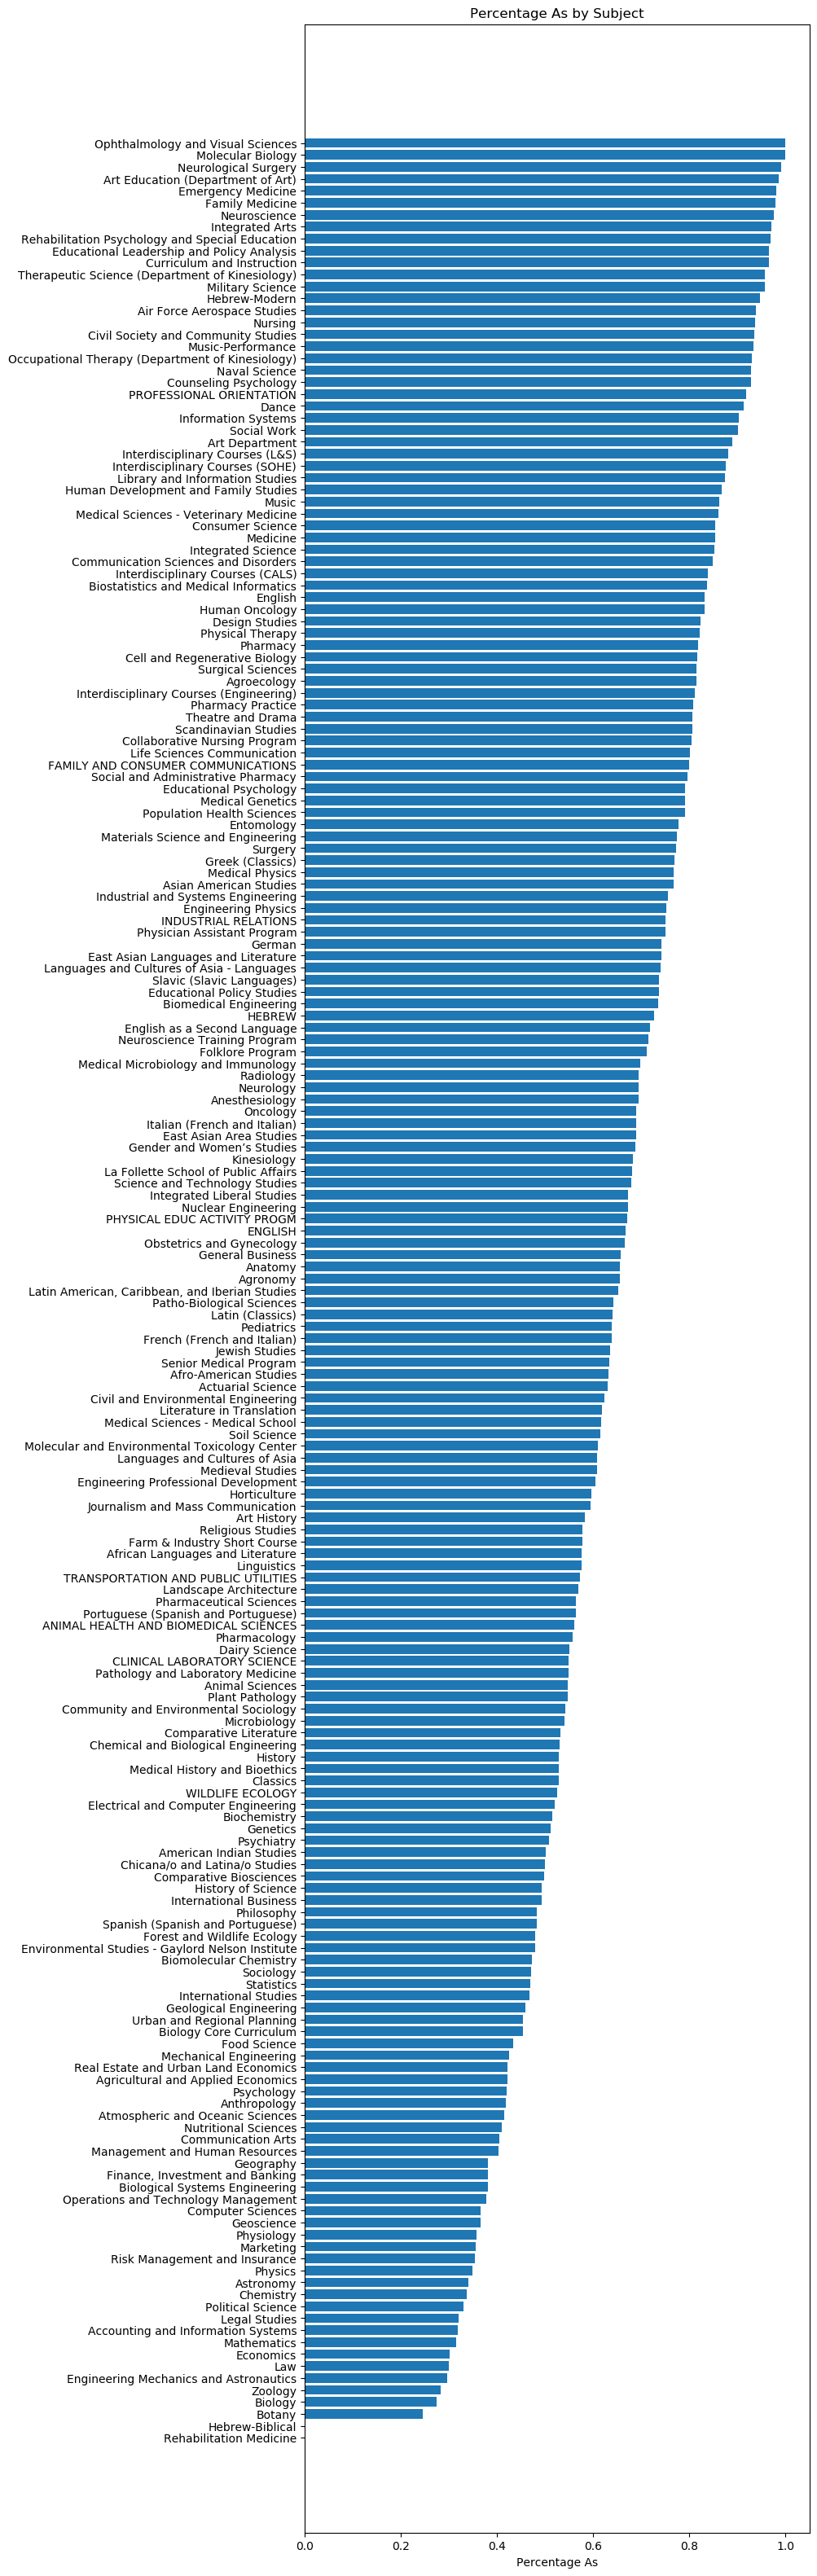

In [147]:
# Set SQL Query to "GROUP BY City"
city = df_subs.SubjectName
orders = df_subs.PerAs

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(8,40))

y_pos = np.arange(len(city))
ax.barh(y_pos, orders, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(city)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Percentage As')
ax.set_title('Percentage As by Subject')
plt.show()

# Do STEM fields have a statistically significant difference in the number of A's earned when compared to the humanities?

***

<b>Null Hypothesis</b>

The number for A's achieved is NOT related to the subject field.

$H_{0} : \mu_{STEM} = \mu_{Humanities}$


<b>Alternative Hypothesis</b>

The number for A's achieved is related to the subject field.

$H_{A} : \mu_{STEM} \neq \mu_{Humanities}$


<b>Method</b>

In [8]:
cur.execute("""SELECT F.name AS instructor, section_type, D.name AS CourseName, H.name AS SubjectName, 
                a_count, b_count, c_count, d_count, f_count, u_count,
                (SUM(a_count), b_count, c_count, d_count, f_count, u_count)
                
                FROM [teachings] A
                
                JOIN [sections] B
                ON (A.section_uuid = B.uuid)
                JOIN [course_offerings] C
                ON (B.course_offering_uuid = C.uuid)
                JOIN [courses] D
                ON (C.course_uuid = D.uuid)
                JOIN [grade_distributions] E
                ON ((B.course_offering_uuid = E.course_offering_uuid))
                JOIN [instructors] F
                ON (A.instructor_id = F.id)
                JOIN [subject_memberships] G
                ON (B.course_offering_uuid = G.course_offering_uuid)
                JOIN [subjects] H
                ON (G.subject_code = H.code)
                
                ORDER BY instructor
                """)
df_teachings = pd.DataFrame(cur.fetchall())
df_teachings.columns = [x[0] for x in cur.description]
df_teachings.head(20)

,instructor,section_type,CourseName,SubjectName,a_count,b_count,c_count,d_count,f_count,u_count
0,JR. JAMES BROWN,SEM,First-Year Seminar in the Humanities,Interdisciplinary Courses (L&S),6,4,0,0,0,0
1,JR. JAMES BROWN,SEM,First-Year Seminar in the Humanities,Interdisciplinary Courses (L&S),5,6,4,0,0,0
2,JR. JAMES BROWN,SEM,First-Year Seminar in the Humanities,Interdisciplinary Courses (L&S),8,0,0,0,0,0
3,JR. JAMES BROWN,SEM,First-Year Seminar in the Humanities,Interdisciplinary Courses (L&S),5,3,2,1,0,0
4,JR. JAMES BROWN,SEM,First-Year Seminar in the Humanities,Interdisciplinary Courses (L&S),5,1,1,1,1,0
5,JR. JAMES BROWN,SEM,First-Year Seminar in the Humanities,Interdisciplinary Courses (L&S),17,0,0,0,0,0
6,JR. JAMES BROWN,SEM,First-Year Seminar in the Humanities,Interdisciplinary Courses (L&S),16,0,0,0,0,0
7,JR. JAMES BROWN,SEM,First-Year Seminar in the Humanities,Interdisciplinary Courses (L&S),5,4,0,0,0,0
8,JR. JAMES BROWN,LEC,Bascom Course,ENGLISH,8,2,3,0,0,0
9,JR. JAMES BROWN,LEC,Bascom Course,ENGLISH,6,2,0,0,0,0


In [9]:
df_teachings.shape

(2206765, 10)

In [10]:
np.array(list(df_teachings.a_count))

array(['6', '5', '8', ..., '5', '5', '5'], dtype='<U3')

<b>Population Mean:</b>

As the grades are strings, they need to be converted to integers


In [11]:
def convert_to_integer(data):
    integers = []
    for i in data:
        integers.append(int(i))
    return integers

In [12]:
df_teachings.a_count = convert_to_integer(df_teachings.a_count)
df_teachings.b_count = convert_to_integer(df_teachings.b_count)
df_teachings.c_count = convert_to_integer(df_teachings.c_count)
df_teachings.d_count = convert_to_integer(df_teachings.d_count)
df_teachings.f_count = convert_to_integer(df_teachings.f_count)
df_teachings.u_count = convert_to_integer(df_teachings.u_count)

In [13]:
df_teachings.section_type.unique()

array(['SEM', 'LEC', 'IND', 'LAB', 'DIS', 'FLD'], dtype=object)

In [14]:
popmean = np.mean(df_teachings.a_count)
popmean

7.296120339048335

In [15]:
instructors = sorted(set(list(df_teachings.instructor)))
len(instructors)

18592

In [16]:
# sns.distplot(df_teachings.a_count)
# sns.distplot(df_teachings.b_count)
# sns.distplot(df_teachings.c_count)
# sns.distplot(df_teachings.d_count)
# sns.distplot(df_teachings.f_count)
# sns.distplot(df_teachings.u_count)

In [17]:
# from statsmodels.formula.api import ols
# formula = 'a_count ~ C(instructor)'  # 
# lm = ols(formula, df_teachings).fit()
# table = sm.stats.anova_lm(lm, typ=2)
# print(table)

Produce a List of all subjects

In [18]:
subjects = sorted(set(list(df_teachings.SubjectName)))
print("Number of Subjects:", len(subjects))
# subjects

Number of Subjects: 193


Split into area of study:
* Science & Engineering
* Humanities & Social Science
* Medical

In [19]:
STEM = ['Biochemistry',
 'Biological Systems Engineering',
 'Biology',
 'Biology Core Curriculum',
 'Biomedical Engineering',
 'Biomolecular Chemistry',
 'Biostatistics and Medical Informatics','CLINICAL LABORATORY SCIENCE',
 'Cell and Regenerative Biology',
 'Chemical and Biological Engineering',
 'Chemistry', 'Computer Sciences', 'Economics','Electrical and Computer Engineering',
 'Engineering Mechanics and Astronautics',
 'Engineering Physics',
 'Engineering Professional Development','Geological Engineering','Industrial and Systems Engineering',
    'Materials Science and Engineering',
 'Mathematics',
 'Mechanical Engineering',
 'Microbiology','Molecular Biology',
 'Molecular and Environmental Toxicology Center',
 'Nuclear Engineering','Physics','Science and Technology Studies','Soil Science','Statistics','WILDLIFE ECOLOGY',
 'Zoology']

In [20]:
HUM = ['Art Department',
 'Art Education (Department of Art)',
 'Art History',
 'Asian American Studies','Anthropology','Chicana/o and Latina/o Studies',
 'Civil Society and Community Studies','Classics','Communication Arts',
 'Communication Sciences and Disorders',
 'Community and Environmental Sociology','Comparative Literature','Counseling Psychology','ENGLISH',
 'East Asian Area Studies',
 'East Asian Languages and Literature','English','FAMILY AND CONSUMER COMMUNICATIONS','Gender and Women’s Studies',
       'Greek (Classics)','History','Integrated Arts',
 'Integrated Liberal Studies', 'Latin (Classics)',
 'Latin American, Caribbean, and Iberian Studies',
 'Law',
 'Legal Studies','Literature in Translation','Political Science','Psychiatry',
 'Psychology','Religious Studies','Sociology','Theatre and Drama']

In [21]:
Medical = ['Anatomy',
 'Anesthesiology','Emergency Medicine','Medical Genetics',
 'Medical History and Bioethics',
 'Medical Microbiology and Immunology',
 'Medical Physics',
 'Medical Sciences - Medical School',
 'Medical Sciences - Veterinary Medicine',
 'Medicine','Neurological Surgery',
 'Neurology',
 'Neuroscience',
 'Neuroscience Training Program','Oncology', 'Obstetrics and Gynecology', 'Ophthalmology and Visual Sciences',
          'Patho-Biological Sciences',
 'Pathology and Laboratory Medicine',
 'Pediatrics',
 'Pharmaceutical Sciences',
 'Pharmacology',
 'Pharmacy',
 'Pharmacy Practice','Physical Therapy',
 'Physician Assistant Program','Radiology','Rehabilitation Medicine',
 'Rehabilitation Psychology and Special Education','Senior Medical Program','Surgery',
 'Surgical Sciences',]

## Analysis - One Sample T-Tests

We can use a one sample t-test as we know what the population mean is of the whole university. Therefore, comparing the the samples of Science & Engineering, Humanities & Social Science & Medical, groups against the the entire school.

<b>Science & Engineering</b>

In [22]:
df_STEM = df_teachings[df_teachings['SubjectName'].isin(STEM)]
df_STEM

,instructor,section_type,CourseName,SubjectName,a_count,b_count,c_count,d_count,f_count,u_count
406,- EKTA,LAB,Introduction to Data Programming,Computer Sciences,40,43,5,1,2,0
407,- EKTA,LAB,Introduction to Data Programming,Computer Sciences,41,31,4,2,1,0
408,. ABHINAVA,DIS,General Physics,Physics,71,81,5,0,1,0
409,. ABHINAVA,DIS,General Physics,Physics,32,51,10,1,1,0
410,. ABHINAVA,DIS,General Physics,Physics,71,81,5,0,1,0
...,...,...,...,...,...,...,...,...,...,...
2206760,ZZ RIFORD,DIS,Dynamics,Mechanical Engineering,10,18,5,3,2,0
2206761,ZZ RIFORD,DIS,Dynamics,Mechanical Engineering,12,13,5,2,1,0
2206762,null,LEC,Structural Theories of Fluid Dynamics,Chemical and Biological Engineering,5,2,0,0,0,0
2206763,null,LEC,Structural Theories of Fluid Dynamics,Chemistry,5,2,0,0,0,0


In [23]:

# sum_students = df_STEM.a_count + df_STEM.b_count + df_STEM.c_count + df_STEM.d_count + df_STEM.f_count + df_STEM.u_count
# df_STEM['n_student']

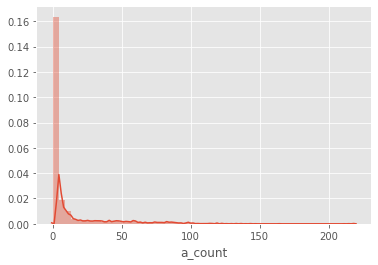

In [24]:
sns.distplot(df_STEM.a_count)

In [25]:
print("NormTest:", stats.normaltest(df_STEM.a_count))

NormTest: NormaltestResult(statistic=494394.39789904223, pvalue=0.0)


In [26]:
df_STEM.shape

(786388, 10)

In [27]:
AsSTEM = create_sample_distribution(df_STEM.a_count, 20000, 50)

In [28]:
popmean - np.mean(AsSTEM)

-1.8004236609516626

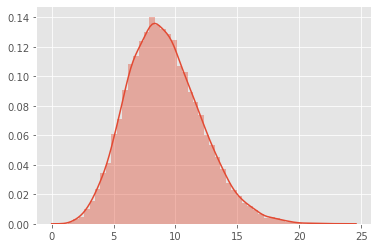

In [29]:
sns.distplot(AsSTEM)

In [30]:
print(stats.normaltest(AsSTEM))
print("Skewness:", stats.skewtest(AsSTEM), 
      "\nKurtosis:", stats.kurtosistest(AsSTEM))

NormaltestResult(statistic=584.5072852432522, pvalue=1.1908462497341397e-127)
Skewness: SkewtestResult(statistic=23.72297387303138, pvalue=2.089244418109763e-124) 
Kurtosis: KurtosistestResult(statistic=4.661308385284412, pvalue=3.1420551319811944e-06)


In [31]:
t_STEM, p_STEM = stats.ttest_1samp(AsSTEM, popmean)
print("STEM: \nT_stat:", t_STEM, "\np_value:", p_STEM)

STEM: 
T_stat: 85.79984155470602 
p_value: 0.0


<b>Humanities & Social Science</b>

In [32]:
df_HUM = df_teachings[df_teachings['SubjectName'].isin(HUM)]

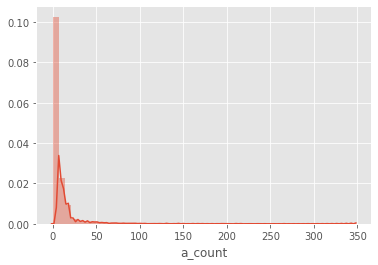

In [33]:
sns.distplot(df_HUM.a_count)

In [34]:
df_HUM.shape

(495381, 10)

In [35]:
AsHUM = create_sample_distribution(df_HUM.a_count, 20000, 50)

In [36]:
popmean - np.mean(AsHUM)

0.3761613390483358

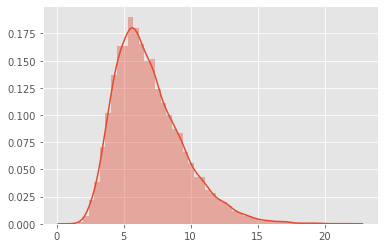

In [37]:
sns.distplot(AsHUM)

In [38]:
print(stats.normaltest(AsHUM))
print("Skewness:", stats.skewtest(AsHUM), 
      "\nKurtosis:", stats.kurtosistest(AsHUM))

NormaltestResult(statistic=2871.439485431833, pvalue=0.0)
Skewness: SkewtestResult(statistic=47.98937487372091, pvalue=0.0) 
Kurtosis: KurtosistestResult(statistic=23.84238630383538, pvalue=1.214626396152494e-125)


In [39]:
t_HUM, p_HUM = stats.ttest_1samp(AsHUM, popmean)
print("HUM: \nT_stat:", t_HUM, "\np_value:", p_HUM)

HUM: 
T_stat: -20.700651943949936 
p_value: 3.320093544011952e-94


In [40]:
one_sample_ttest(AsSTEM, popmean, 0.05)

Reject Null_H! The results are statistically significant.
Mean Diff: -1.8004236609516626
t-stat =  85.8 
t_crit 1.645 
P_value =  0.0 
Alpha 0.05


In [41]:
one_sample_ttest(AsHUM, popmean, 0.05)

Reject Null_H! The results are statistically significant.
Mean Diff: 0.3761613390483358
t-stat =  -20.701 
t_crit 1.645 
P_value =  0.0 
Alpha 0.05


<b>Medical</b>

In [42]:
df_Medical = df_teachings[df_teachings['SubjectName'].isin(Medical)]

In [43]:
df_Medical.shape

(243021, 10)

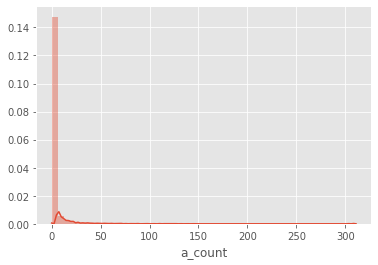

In [44]:
sns.distplot(df_Medical.a_count)

In [45]:
AsMedical = create_sample_distribution(df_Medical.a_count, 20000, 50)

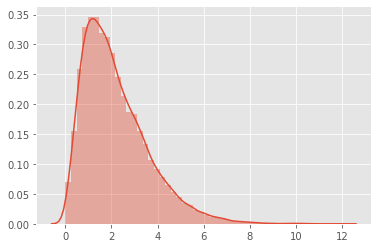

In [46]:
sns.distplot(AsMedical)

In [47]:
print(stats.normaltest(AsMedical))
print("Skewness:", stats.skewtest(AsMedical), 
      "\nKurtosis:", stats.kurtosistest(AsMedical))

NormaltestResult(statistic=3875.3141207737194, pvalue=0.0)
Skewness: SkewtestResult(statistic=54.942485769549734, pvalue=0.0) 
Kurtosis: KurtosistestResult(statistic=29.268368219573578, pvalue=2.6217595971406036e-188)


In [48]:
t_Medical, p_Medical = stats.ttest_1samp(AsMedical, popmean)
print("HUM: \nT_stat:", t_Medical, "\np_value:", p_Medical)

HUM: 
T_stat: -511.66154074250085 
p_value: 0.0


## Comparison between Science & Engineering and  Humanities & Social Science using Two-Sample T-Tests:

Students-T as the are equal samples due to the get samples

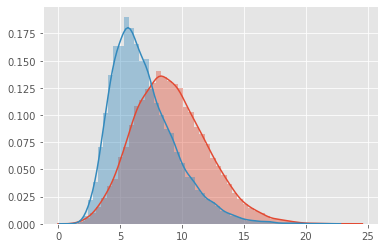

In [49]:
sns.distplot(AsSTEM)
sns.distplot(AsHUM)

In [50]:
def find_t_crit(sample1, sample2, alpha):
    return stats.t.ppf(1-(alpha/2), (len(sample1)+len(sample2)-2))

In [51]:
find_t_crit(AsSTEM, AsHUM, 0.05)

1.9600232960505766

In [52]:
def two_sample_ttest_student_t(sample1, sample2, alpha):
    return stats.ttest_ind(sample1, sample2, equal_var=False)

In [53]:
two_sample_ttest_student_t(AsSTEM, AsHUM, 0.05)

Ttest_indResult(statistic=78.41166776026625, pvalue=0.0)

In [54]:
two_sample_ttest(AsSTEM, AsHUM, 0.05)
ES, power = power_and_effect_size(AsSTEM, AsHUM, 0.05)
print("Cohen_d Effect Size:", ES, "\nPower:", power)

Two Tail T-test:
---------------------------------------------------------------
Obs Number: Sample_1 = 20000   Sample_2 = 20000
Sample Means: Sample_1 = 9.097   Sample_2 = 6.92
Mean Differance: 2.177
---------------------------------------------------------------
t-crit: 1.9600232960505766 
t-stat: 78.41166776026627 
P-value: 0.0 
Alpha(2-Tail): 0.025
---------------------------------------------------------------
|t_stat| > t_crit: True
P_value < Alpha(2-Tail): True

Reject Null_H! The results are statistically significant.
---------------------------------------------------------------
Cohen_d Effect Size: 0.78 
Power: 1.0


<b>Observations</b>

Science & Engineering obtains statistically more "As" than the Humanities & Social Science 

### Multi-Comparison

In [55]:
# from statsmodels.stats.multicomp import pairwise_tukeyhsd
# from statsmodels.stats.multicomp import MultiComparison

# mc = MultiComparison(df_orders_anova['Quantity'], df_orders_anova['Discount'])
# mc_results = mc.tukeyhsd() # Default is 5% alpha
# print(mc_results)

# mc_results = mc_results.plot_simultaneous(figsize=(16,14))
# plt.show()

# Does time of day have a statistically significant correlation with the number of A's earned in a course?

In [56]:
# cur.execute("""SELECT *
#                 FROM [schedules]
#                 """)
# df = pd.DataFrame(cur.fetchall())
# df.columns = [x[0] for x in cur.description]
# # df

In [57]:
cur.execute("""SELECT F.name AS instructor, section_type, D.name AS CourseName, H.name AS SubjectName, 
                a_count, b_count, c_count, d_count, f_count, u_count,
                mon, tues, wed, thurs, fri, sat, sun
                
                FROM [teachings] A
                
                JOIN [sections] B
                ON (A.section_uuid = B.uuid)
                JOIN [course_offerings] C
                ON (B.course_offering_uuid = C.uuid)
                JOIN [courses] D
                ON (C.course_uuid = D.uuid)
                JOIN [grade_distributions] E
                ON ((B.course_offering_uuid = E.course_offering_uuid))
                JOIN [instructors] F
                ON (A.instructor_id = F.id)
                JOIN [subject_memberships] G
                ON (B.course_offering_uuid = G.course_offering_uuid)
                JOIN [subjects] H
                ON (G.subject_code = H.code)
                JOIN [schedules] I
                ON (B.schedule_uuid = I.uuid)
                
                ORDER BY instructor
                """)
df_sched = pd.DataFrame(cur.fetchall())
df_sched.columns = [x[0] for x in cur.description]
# df_sched.head(20)

In [58]:
df_sched.head(20)

,instructor,section_type,CourseName,SubjectName,a_count,b_count,c_count,d_count,f_count,u_count,mon,tues,wed,thurs,fri,sat,sun
0,JR. JAMES BROWN,SEM,First-Year Seminar in the Humanities,Interdisciplinary Courses (L&S),6,4,0,0,0,0,true,false,false,false,false,false,false
1,JR. JAMES BROWN,SEM,First-Year Seminar in the Humanities,Interdisciplinary Courses (L&S),5,6,4,0,0,0,true,false,false,false,false,false,false
2,JR. JAMES BROWN,SEM,First-Year Seminar in the Humanities,Interdisciplinary Courses (L&S),8,0,0,0,0,0,true,false,false,false,false,false,false
3,JR. JAMES BROWN,SEM,First-Year Seminar in the Humanities,Interdisciplinary Courses (L&S),5,3,2,1,0,0,true,false,false,false,false,false,false
4,JR. JAMES BROWN,SEM,First-Year Seminar in the Humanities,Interdisciplinary Courses (L&S),5,1,1,1,1,0,true,false,false,false,false,false,false
5,JR. JAMES BROWN,SEM,First-Year Seminar in the Humanities,Interdisciplinary Courses (L&S),17,0,0,0,0,0,true,false,false,false,false,false,false
6,JR. JAMES BROWN,SEM,First-Year Seminar in the Humanities,Interdisciplinary Courses (L&S),16,0,0,0,0,0,true,false,false,false,false,false,false
7,JR. JAMES BROWN,SEM,First-Year Seminar in the Humanities,Interdisciplinary Courses (L&S),5,4,0,0,0,0,true,false,false,false,false,false,false
8,JR. JAMES BROWN,LEC,Bascom Course,ENGLISH,8,2,3,0,0,0,true,false,false,false,false,false,false
9,JR. JAMES BROWN,LEC,Bascom Course,ENGLISH,6,2,0,0,0,0,true,false,false,false,false,false,false


In [59]:
df_sched.a_count = convert_to_integer(df_sched.a_count)
df_sched.b_count = convert_to_integer(df_sched.b_count)
df_sched.c_count = convert_to_integer(df_sched.c_count)
df_sched.d_count = convert_to_integer(df_sched.d_count)
df_sched.f_count = convert_to_integer(df_sched.f_count)
df_sched.u_count = convert_to_integer(df_sched.u_count)

In [60]:
def convert_to_asdf(data):
    asdf = []
    for i in data:
        if i == 'true':
            asdf.append(True)
        else:
            asdf.append(False)
    return asdf

In [61]:
df_sched.mon = convert_to_asdf(df_sched.mon)
df_sched.tues = convert_to_asdf(df_sched.tues)
df_sched.wed = convert_to_asdf(df_sched.wed)
df_sched.thurs = convert_to_asdf(df_sched.thurs)
df_sched.fri = convert_to_asdf(df_sched.fri)
df_sched.sat = convert_to_asdf(df_sched.sat)
df_sched.sun = convert_to_asdf(df_sched.sun)

In [62]:
df_sched

,instructor,section_type,CourseName,SubjectName,a_count,b_count,c_count,d_count,f_count,u_count,mon,tues,wed,thurs,fri,sat,sun
0,JR. JAMES BROWN,SEM,First-Year Seminar in the Humanities,Interdisciplinary Courses (L&S),6,4,0,0,0,0,True,False,False,False,False,False,False
1,JR. JAMES BROWN,SEM,First-Year Seminar in the Humanities,Interdisciplinary Courses (L&S),5,6,4,0,0,0,True,False,False,False,False,False,False
2,JR. JAMES BROWN,SEM,First-Year Seminar in the Humanities,Interdisciplinary Courses (L&S),8,0,0,0,0,0,True,False,False,False,False,False,False
3,JR. JAMES BROWN,SEM,First-Year Seminar in the Humanities,Interdisciplinary Courses (L&S),5,3,2,1,0,0,True,False,False,False,False,False,False
4,JR. JAMES BROWN,SEM,First-Year Seminar in the Humanities,Interdisciplinary Courses (L&S),5,1,1,1,1,0,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206760,ZZ RIFORD,DIS,Dynamics,Mechanical Engineering,10,18,5,3,2,0,False,False,True,False,True,False,False
2206761,ZZ RIFORD,DIS,Dynamics,Mechanical Engineering,12,13,5,2,1,0,False,False,True,False,True,False,False
2206762,null,LEC,Structural Theories of Fluid Dynamics,Chemical and Biological Engineering,5,2,0,0,0,0,False,True,False,True,False,False,False
2206763,null,LEC,Structural Theories of Fluid Dynamics,Chemistry,5,2,0,0,0,0,False,True,False,True,False,False,False


In [125]:
print("Percentage As Achived:", round((df_sched.a_count.sum()/(df_sched.a_count.sum() 
                                  + df_sched.b_count.sum() 
                                  + df_sched.c_count.sum() 
                                  + df_sched.d_count.sum() 
                                  + df_sched.f_count.sum() 
                                  + df_sched.u_count.sum()))*100, 3))

Percentage As Achived: 42.759


In [63]:
popmean = np.mean(df_sched.a_count)
popmean

7.296120339048335

In [64]:
df_mon = df_sched.loc[df_sched['mon'] == True]
df_tues = df_sched.loc[df_sched['tues'] == True]
df_wed = df_sched.loc[df_sched['wed'] == True]
df_thurs = df_sched.loc[df_sched['thurs'] == True]
df_fri = df_sched.loc[df_sched['fri'] == True]
df_sat = df_sched.loc[df_sched['sat'] == True]
df_sun = df_sched.loc[df_sched['sun'] == True]

In [65]:
days = [df_mon, df_tues, df_wed, df_thurs, df_fri, df_sat, df_sun]
week_days = [df_mon, df_tues, df_wed, df_thurs, df_fri]

In [66]:
# AsMon = list(df_mon.a_count)
# AsTues = list(df_tues.a_count)
# AsWed = list(df_wed.a_count)
# AsThurs = list(df_thurs.a_count)
# AsFir = list(df_fri.a_count)
# AsSat = list(df_sat.a_count)
# AsSun = list(df_sun.a_count)

401317
376194
409313
354897
273262
47543
385


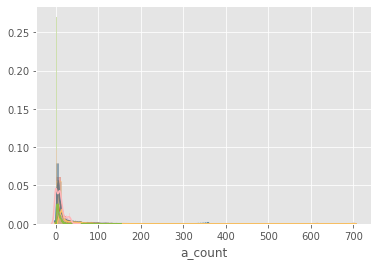

In [67]:
for d in days:
    print(len(d))
    sns.distplot(d.a_count)

In [68]:
sample_days = []
for d in week_days:
    sample_days.append(create_sample_distribution(d.a_count, 10000, 50))

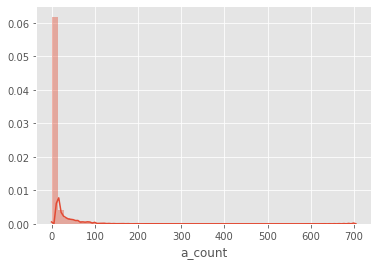

In [69]:
sns.distplot(df_sched.a_count)

In [70]:
total_As = create_sample_distribution(df_sched.a_count, 10000, 50)

7.276368


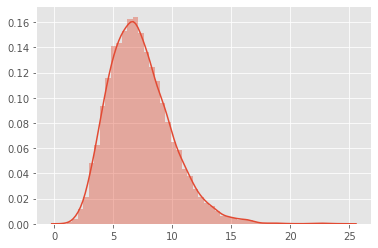

In [71]:
print(np.mean(total_As))
sns.distplot(total_As)

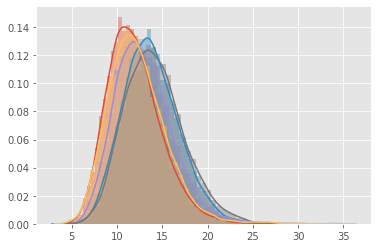

In [72]:
for d in sample_days:
    sns.distplot(d)

In [77]:
i=0
while i < 5:
    print(f"\nDay: {i+1}")
    one_sample_ttest(sample_days[i], popmean, 0.05)
    
    i+=1


Day: 1
Reject Null_H! The results are statistically significant.
Mean Diff: -4.655145660951663
t-stat =  157.852 
t_crit 1.645 
P_value =  0.0 
Alpha 0.05

Day: 2
Reject Null_H! The results are statistically significant.
Mean Diff: -6.467875660951663
t-stat =  211.296 
t_crit 1.645 
P_value =  0.0 
Alpha 0.05

Day: 3
Reject Null_H! The results are statistically significant.
Mean Diff: -5.684627660951665
t-stat =  178.961 
t_crit 1.645 
P_value =  0.0 
Alpha 0.05

Day: 4
Reject Null_H! The results are statistically significant.
Mean Diff: -6.817577660951666
t-stat =  210.343 
t_crit 1.645 
P_value =  0.0 
Alpha 0.05

Day: 5
Reject Null_H! The results are statistically significant.
Mean Diff: -4.951173660951665
t-stat =  154.802 
t_crit 1.645 
P_value =  0.0 
Alpha 0.05


In [ ]:
round((df_TheraSci.a_count.sum()/(df_TheraSci.a_count.sum() 
                                  + df_TheraSci.b_count.sum() 
                                  + df_TheraSci.c_count.sum() 
                                  + df_TheraSci.d_count.sum() 
                                  + df_TheraSci.f_count.sum() 
                                  + df_TheraSci.u_count.sum()))*100, 3)

## Subject Multi Comparison

In [85]:
from statsmodels.formula.api import ols
formula = 'a_count ~ C(SubjectName)' 
lm = ols(formula, df_sched).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

AttributeError: module 'statsmodels.stats' has no attribute 'anova_lm'

                                           Multiple Comparison of Means - Tukey HSD, FWER=0.05                                            
                     group1                                           group2                      meandiff p-adj   lower    upper   reject
------------------------------------------------------------------------------------------------------------------------------------------
           ANIMAL HEALTH AND BIOMEDICAL SCIENCES               Accounting and Information Systems   7.8659  0.001   6.0768   9.6551   True
           ANIMAL HEALTH AND BIOMEDICAL SCIENCES                                Actuarial Science  15.9834  0.001  11.6551  20.3118   True
           ANIMAL HEALTH AND BIOMEDICAL SCIENCES                 African Languages and Literature   9.0389  0.001   6.9794  11.0984   True
           ANIMAL HEALTH AND BIOMEDICAL SCIENCES                            Afro-American Studies  37.0211  0.001  34.5218  39.5205   True
           ANIMAL HEALTH AN

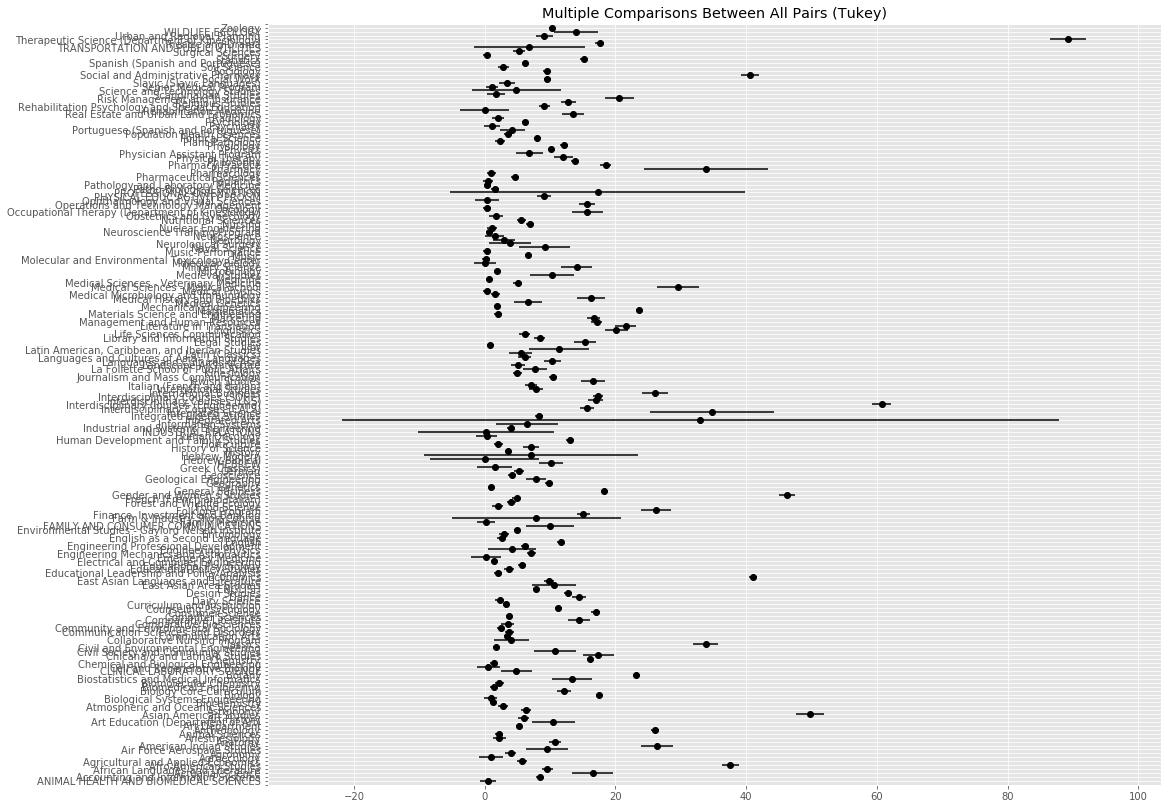

In [91]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(df_sched['a_count'], df_sched['SubjectName'])
mc_results = mc.tukeyhsd() # Default is 5% alpha
print(mc_results)

mc_results_plot = mc_results.plot_simultaneous(figsize=(16,14))
plt.show()

In [94]:
df_SubjectComp = pd.DataFrame(data=mc_results._results_table.data[1:], columns=mc_results._results_table.data[0])
df_SubjectComp = df_SubjectComp.loc[df_SubjectComp['reject']==True]
df_SubjectComp.sort_values(by=['meandiff'], inplace=True)

In [95]:
df_SubjectComp.head(20)

,group1,group2,meandiff,p-adj,lower,upper,reject
18522,Therapeutic Science (Department of Kinesiology),Urban and Regional Planning,-80.1058,0.001,-84.1460,-76.0655,True
18524,Therapeutic Science (Department of Kinesiology),Zoology,-78.9009,0.001,-82.5459,-75.2560,True
18523,Therapeutic Science (Department of Kinesiology),WILDLIFE ECOLOGY,-75.3173,0.001,-80.9347,-69.7000,True
13946,Interdisciplinary Courses (Engineering),Rehabilitation Medicine,-60.7419,0.001,-65.8612,-55.6226,True
13907,Interdisciplinary Courses (Engineering),Molecular Biology,-60.7161,0.001,-63.7066,-57.7256,True
13908,Interdisciplinary Courses (Engineering),Molecular and Environmental Toxicology Center,-60.5611,0.001,-62.6883,-58.4340,True
13900,Interdisciplinary Courses (Engineering),Medical Physics,-60.4593,0.001,-62.5575,-58.3611,True
13960,Interdisciplinary Courses (Engineering),Surgery,-60.4347,0.001,-62.5194,-58.3501,True
13910,Interdisciplinary Courses (Engineering),Music-Performance,-60.4222,0.001,-62.4839,-58.3605,True
13921,Interdisciplinary Courses (Engineering),Oncology,-60.3958,0.001,-62.5160,-58.2757,True


In [105]:
df_SubjectComp.tail(20)

,group1,group2,meandiff,p-adj,lower,upper,reject
15284,Law,Therapeutic Science (Department of Kinesiology),88.3475,0.001,84.6979,91.9970,True
17198,Neuroscience Training Program,Therapeutic Science (Department of Kinesiology),88.5350,0.001,84.8817,92.1884,True
16508,Medicine,Therapeutic Science (Department of Kinesiology),88.5818,0.001,84.9298,92.2337,True
5321,Cell and Regenerative Biology,Therapeutic Science (Department of Kinesiology),88.6536,0.001,84.3422,92.9650,True
188,ANIMAL HEALTH AND BIOMEDICAL SCIENCES,Therapeutic Science (Department of Kinesiology),88.6837,0.001,84.6834,92.6839,True
17783,Pediatrics,Therapeutic Science (Department of Kinesiology),88.7039,0.001,84.9288,92.4791,True
17744,Pathology and Laboratory Medicine,Therapeutic Science (Department of Kinesiology),88.8391,0.001,85.1700,92.5083,True
17578,Ophthalmology and Visual Sciences,Therapeutic Science (Department of Kinesiology),88.8538,0.001,84.4286,93.2789,True
17489,Oncology,Therapeutic Science (Department of Kinesiology),88.8817,0.001,85.1804,92.5829,True
16928,Music-Performance,Therapeutic Science (Department of Kinesiology),88.9081,0.001,85.2400,92.5761,True


Investigate: Therapeutic Science (Department of Kinesiology) & Interdisciplinary Courses (Engineering)

In [117]:
df_TheraSci = df_sched.loc[df_sched['SubjectName'] == "Therapeutic Science (Department of Kinesiology)"]
df_TheraSci.describe()

,a_count,b_count,c_count,d_count,f_count,u_count
count,483.000000,483.000000,483.000000,483.000000,483.000000,483.0
mean,89.227743,2.888199,0.445135,0.389234,0.289855,0.0
std,77.172342,3.225920,0.971904,0.810747,0.643222,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,12.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,119.000000,2.000000,0.000000,0.000000,0.000000,0.0
75%,167.000000,5.000000,0.000000,0.000000,0.000000,0.0
max,199.000000,12.000000,5.000000,4.000000,2.000000,0.0


In [120]:
round((df_TheraSci.a_count.sum()/(df_TheraSci.a_count.sum() 
                                  + df_TheraSci.b_count.sum() 
                                  + df_TheraSci.c_count.sum() 
                                  + df_TheraSci.d_count.sum() 
                                  + df_TheraSci.f_count.sum() 
                                  + df_TheraSci.u_count.sum()))*100, 3)

95.697

In [119]:
df_InterEng = df_sched.loc[df_sched['SubjectName'] == "Interdisciplinary Courses (Engineering)"]
df_InterEng.describe()

,a_count,b_count,c_count,d_count,f_count,u_count
count,1604.000000,1604.000000,1604.000000,1604.000000,1604.000000,1604.000000
mean,60.741895,12.427057,1.173940,0.377182,0.203865,0.004988
std,50.878834,12.031682,1.757343,0.806556,0.512073,0.099782
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,51.000000,10.000000,0.000000,0.000000,0.000000,0.000000
75%,107.000000,23.000000,2.000000,1.000000,0.000000,0.000000
max,193.000000,59.000000,8.000000,5.000000,4.000000,2.000000


In [121]:
round((df_InterEng.a_count.sum()/(df_InterEng.a_count.sum() 
                                  + df_InterEng.b_count.sum() 
                                  + df_InterEng.c_count.sum() 
                                  + df_InterEng.d_count.sum() 
                                  + df_InterEng.f_count.sum() 
                                  + df_InterEng.u_count.sum()))*100, 3)

81.066